In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)

os.chdir("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from sklearn.model_selection import train_test_split
from src.datasets.datasets import AllModelsOutputDataset, CPDDatasets
from src.ensembles.distances import MMD_batch
from src.ensembles.ensembles import EnsembleCPDModel
from src.metrics.evaluation_pipelines import (
    evaluate_distance_ensemble_model,
)
from src.metrics.metrics_utils import collect_model_predictions_on_set
from src.utils.calibration import (
    calibrate_all_models_in_ensemble,
)
from src.utils.fix_seeds import fix_seeds
from torch.utils.data import DataLoader

SEED = 42
fix_seeds(SEED)

%load_ext autoreload
%autoreload
%matplotlib inline

comet_ml is installed but `COMET_API_KEY` is not set.


In [7]:
ensemble_size = 10
bs = 16
window_size = 2

history = torch.rand((bs, window_size, ensemble_size))
future = torch.rand((bs, window_size, ensemble_size))

mmd_dist = MMD_batch(history, future, kernel="rbf")
mmd_dist

tensor([0.0864, 0.1259, 0.1666, 0.3640, 0.1124, 0.2373, 0.1748, 0.1238, 0.1217,
        0.1315, 0.0893, 0.1246, 0.1939, 0.1920, 0.1963, 0.1644])

# max F1 vs Wasserstein threshold

# HAR

In [3]:
model_type = "seq2seq"

experiments_name = "human_activity"
path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"
path_to_models_folder = "saved_models/bce/human_activity/full_sample/ens_1"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

_, val_dataset = train_test_split(train_dataset, test_size=0.4, random_state=42)
val_dataloader = DataLoader(
    val_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

In [4]:
test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_bce,
    test_dataloader,
    model_type="ensemble_all_models",
    device="cpu",
    verbose=True,
)

out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)
test_out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

  0%|          | 0/21 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 21/21 [00:06<00:00,  3.44it/s]


In [5]:
outs_batch, labels = next(iter(test_out_dataloader))
outs_batch.shape

torch.Size([128, 10, 20])

In [6]:
outs_batch.permute(0, 2, 1).shape

torch.Size([128, 20, 10])

In [ ]:
MMD_batch()

In [7]:
threshold_number = 300
threshold_list = np.linspace(0, 1, threshold_number)

In [9]:
test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_bce,
    test_dataloader,
    model_type="ensemble_all_models",
    device="cpu",
    verbose=False,
)

out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)

out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

# res_start, best_th_start = evaluate_distance_ensemble_model(
#     ens_model=ens_bce,
#     threshold_list=threshold_list,
#     output_dataloader=out_dataloader,
#     margin_list=[1, 2, 4],
#     window_size=2,
#     anchor_window_type="start",
#     distance="wasserstein_1d",
#     device="cpu",
#     verbose=True,
# )

res_prev, best_th_prev = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="prev",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

100%|██████████| 300/300 [07:28<00:00,  1.50s/it]

Results for best threshold = 0.2842809364548495
AUDC: 0.0, Time to FA: 11.2184, DD: 1.1339, F1: 0.9754, Cover: 0.912, Max Cover: 0.912
Max F1 with margin 1: 0.941
Max F1 with margin 2: 0.9695
Max F1 with margin 4: 0.9727


In [65]:
outs_tensor = torch.hstack([out for out in test_out_bank])
labels_tensor = torch.vstack([labels for labels in test_labels_bank])
outs_tensor.shape, labels_tensor.shape

(torch.Size([10, 1337, 20]), torch.Size([1337, 20]))

In [66]:
torch.save(outs_tensor, "saved_outputs/bce/human_activity/all_models_ens_1_outputs.pt")
torch.save(labels_tensor, "saved_outputs/bce/human_activity/all_models_ens_1_labels.pt")

In [11]:
# f1_dict_start = {th: v[3] for th, v in res_start.items()}
# f1_m2_list_start = {th: v[6][2] for th, v in res_start.items()}

f1_dict_prev = {th: v[3] for th, v in res_prev.items()}
# f1_m2_list_prev = {th: v[6][2] for th, v in res_prev.items()}

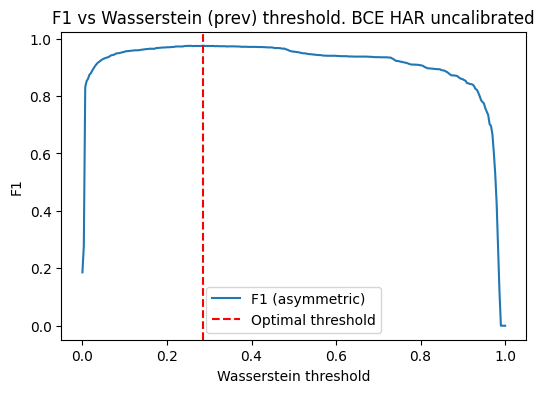

In [12]:
# plt.figure(figsize=(6, 4))
# plt.plot(f1_dict_start.keys(), f1_dict_start.values(), label="F1 (asymmetric)")
# plt.plot(f1_m2_list_start.keys(), f1_m2_list_start.values(), label="F1 (m = 2)")
# plt.axvline(best_th_start, c="r", linestyle="--", label="Optimal threshold")
# plt.xlabel("Wasserstein threshold", fontsize=10)
# plt.ylabel("F1", fontsize=10)
# plt.title("F1 vs Wasserstein (start) threshold. BCE HAR uncalibrated", fontsize=12)
# plt.legend(fontsize=10)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.show()

# plt.figure(figsize=(6, 4))
# plt.plot(f1_dict_prev.keys(), f1_dict_prev.values(), label="F1 (asymmetric)")
# plt.plot(f1_m2_list_prev.keys(), f1_m2_list_prev.values(), label="F1 (m = 2)")
# plt.axvline(best_th_prev, c="r", linestyle="--", label="Optimal threshold")
# plt.xlabel("Wasserstein threshold", fontsize=10)
# plt.ylabel("F1", fontsize=10)
# plt.title("F1 vs Wasserstein (prev) threshold. BCE HAR uncalibrated", fontsize=12)
# plt.legend(fontsize=10)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.show()

In [13]:
cal_models_list = calibrate_all_models_in_ensemble(
    ens_bce,
    test_dataloader,
    cal_type="beta",
    verbose=False,
    device="cpu",
)

test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_bce,
    val_dataloader,
    model_type="ensemble_all_models",
    device="cpu",
    verbose=False,
)

out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)

out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

# res_start_cal, best_th_start_cal = evaluate_distance_ensemble_model(
#     ens_model=ens_bce,
#     threshold_list=threshold_list,
#     output_dataloader=out_dataloader,
#     margin_list=[1, 2, 4],
#     window_size=2,
#     anchor_window_type="start",
#     distance="wasserstein_1d",
#     device="cpu",
#     verbose=True,
# )

res_prev_cal, best_th_prev_cal = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="prev",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

100%|██████████| 300/300 [07:47<00:00,  1.56s/it]

Results for best threshold = 0.26755852842809363
AUDC: 0.0, Time to FA: 11.861, DD: 1.1669, F1: 0.9665, Cover: 0.9162, Max Cover: 0.9162
Max F1 with margin 1: 0.9336
Max F1 with margin 2: 0.9643
Max F1 with margin 4: 0.9683


In [69]:
outs_tensor = torch.hstack([out for out in test_out_bank])
labels_tensor = torch.vstack([labels for labels in test_labels_bank])
outs_tensor.shape, labels_tensor.shape

(torch.Size([10, 1337, 20]), torch.Size([1337, 20]))

In [70]:
torch.save(
    outs_tensor, "saved_outputs/bce/human_activity/all_models_ens_1_outputs_cal.pt"
)
torch.save(
    labels_tensor, "saved_outputs/bce/human_activity/all_models_ens_1_labels_cal.pt"
)

In [15]:
# f1_dict_start_cal = {th: v[3] for th, v in res_start_cal.items()}
# f1_m2_list_start_cal = {th: v[6][2] for th, v in res_start_cal.items()}

f1_dict_prev_cal = {th: v[3] for th, v in res_prev_cal.items()}
# f1_m2_list_prev_cal = {th: v[6][2] for th, v in res_prev_cal.items()}

In [21]:
FONTSIZE = 16

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
c0 = colors[0]
c1 = colors[1]

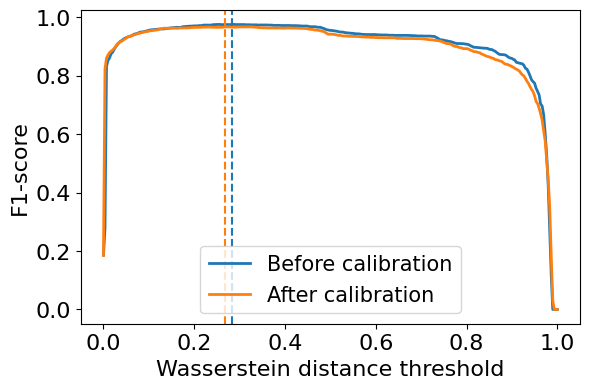

In [31]:
# plt.figure(figsize=(6, 4))
# plt.plot(f1_dict_start_cal.keys(), f1_dict_start_cal.values(), label="F1 (asymmetric)")
# plt.plot(f1_m2_list_start_cal.keys(), f1_m2_list_start_cal.values(), label="F1 (m = 2)")
# plt.axvline(best_th_start_cal, c="r", linestyle="--", label="Optimal threshold")
# plt.xlabel("Wasserstein threshold", fontsize=10)
# plt.ylabel("F1", fontsize=10)
# plt.title("F1 vs Wasserstein (start) threshold. BCE HAR Beta-calibrated", fontsize=12)
# plt.legend(fontsize=10)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.show()

plt.figure(figsize=(6, 4))
plt.plot(
    f1_dict_prev.keys(),
    f1_dict_prev.values(),
    linewidth=2,
    label="Before calibration",
    c=c0,
)
plt.plot(
    f1_dict_prev_cal.keys(),
    f1_dict_prev_cal.values(),
    linewidth=2,
    label="After calibration",
    c=c1,
)
plt.axvline(best_th_prev, linestyle="--", c=c0)  # label="$h^{*}$ before calibration"
plt.axvline(best_th_prev_cal, linestyle="--", c=c1)  # label="$h^{*}$ after calibration"
plt.xlabel("Wasserstein distance threshold", fontsize=FONTSIZE)
plt.ylabel("F1-score", fontsize=FONTSIZE)
plt.legend(fontsize=FONTSIZE - 1)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig("pictures/calibration/th_graphs/th_range_har.pdf", dpi=300)
plt.show()

# Explosions

In [32]:
model_type = "seq2seq"

experiments_name = "explosion"
path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"
path_to_models_folder = (
    "saved_models/bce/explosion/layer_norm/train_anomaly_num_155/ens_1"
)

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

_, val_dataset = train_test_split(train_dataset, test_size=0.4, random_state=42)
val_dataloader = DataLoader(
    val_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [36]:
test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_bce,
    test_dataloader,
    model_type="ensemble_all_models",
    device="cuda",
    verbose=True,
)

out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)
out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

# res_start, best_th_start = evaluate_distance_ensemble_model(
#     ens_model=ens_bce,
#     threshold_list=threshold_list,
#     output_dataloader=out_dataloader,
#     margin_list=[1, 2, 4],
#     window_size=2,
#     anchor_window_type="start",
#     distance="wasserstein_1d",
#     device="cpu",
#     verbose=True,
# )

res_prev, best_th_prev = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="prev",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 300/300 [04:44<00:00,  1.05it/s]

Results for best threshold = 0.25418060200668896
AUDC: 0.0, Time to FA: 15.619, DD: 0.1238, F1: 0.7586, Cover: 0.9854, Max Cover: 0.9854
Max F1 with margin 1: 0.56
Max F1 with margin 2: 0.6154
Max F1 with margin 4: 0.7586


In [40]:
f1_dict_prev = {th: v[3] for th, v in res_prev.items()}

In [77]:
outs_tensor = torch.hstack([out for out in test_out_bank])
labels_tensor = torch.vstack([labels for labels in test_labels_bank])
outs_tensor.shape, labels_tensor.shape

(torch.Size([10, 315, 16]), torch.Size([315, 16]))

In [78]:
torch.save(outs_tensor, "saved_outputs/bce/explosion/all_models_ens_1_outputs.pt")
torch.save(labels_tensor, "saved_outputs/bce/explosion/all_models_ens_1_labels.pt")

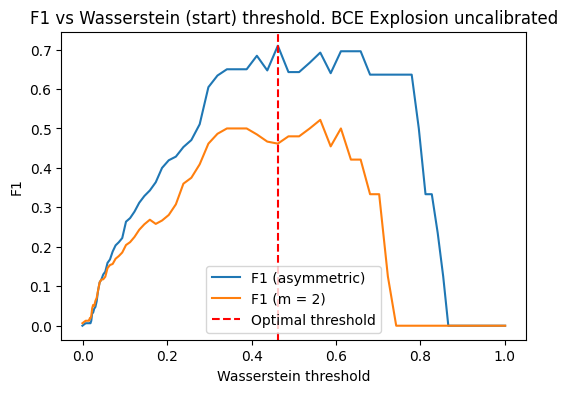

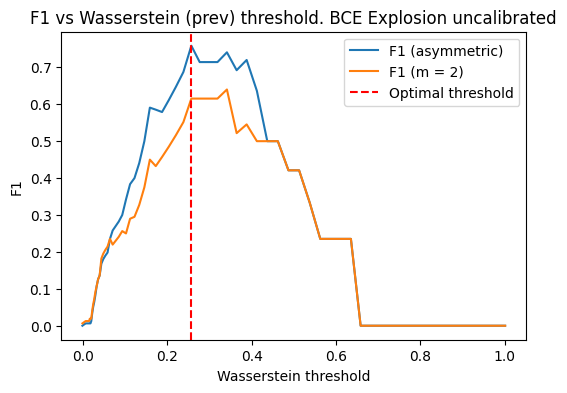

In [79]:
# f1_dict_start = {th: v[3] for th, v in res_start.items()}
# f1_m2_list_start = {th: v[6][2] for th, v in res_start.items()}

# f1_dict_prev = {th: v[3] for th, v in res_prev.items()}
# f1_m2_list_prev = {th: v[6][2] for th, v in res_prev.items()}

# plt.figure(figsize=(6, 4))
# plt.plot(f1_dict_start.keys(), f1_dict_start.values(), label="F1 (asymmetric)")
# plt.plot(f1_m2_list_start.keys(), f1_m2_list_start.values(), label="F1 (m = 2)")
# plt.axvline(best_th_start, c="r", linestyle="--", label="Optimal threshold")
# plt.xlabel("Wasserstein threshold", fontsize=10)
# plt.ylabel("F1", fontsize=10)
# plt.title(
#     "F1 vs Wasserstein (start) threshold. BCE Explosion uncalibrated", fontsize=12
# )
# plt.legend(fontsize=10)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.show()

# plt.figure(figsize=(6, 4))
# plt.plot(f1_dict_prev.keys(), f1_dict_prev.values(), label="F1 (asymmetric)")
# plt.plot(f1_m2_list_prev.keys(), f1_m2_list_prev.values(), label="F1 (m = 2)")
# plt.axvline(best_th_prev, c="r", linestyle="--", label="Optimal threshold")
# plt.xlabel("Wasserstein threshold", fontsize=10)
# plt.ylabel("F1", fontsize=10)
# plt.title("F1 vs Wasserstein (prev) threshold. BCE Explosion uncalibrated", fontsize=12)
# plt.legend(fontsize=10)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.show()

In [37]:
cal_models_list = calibrate_all_models_in_ensemble(
    ens_bce,
    val_dataloader,
    cal_type="beta",
    verbose=True,
    device="cuda",
)

test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_bce,
    test_dataloader,
    model_type="ensemble_all_models",
    device="cuda",
    verbose=True,
)

out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)

out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

# res_start_cal, best_th_start_cal = evaluate_distance_ensemble_model(
#     ens_model=ens_bce,
#     threshold_list=threshold_list,
#     output_dataloader=out_dataloader,
#     margin_list=[1, 2, 4],
#     window_size=2,
#     anchor_window_type="start",
#     distance="wasserstein_1d",
#     device="cpu",
#     verbose=True,
# )

res_prev_cal, best_th_prev_cal = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="prev",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


 12%|█▎        | 1/8 [00:00<00:04,  1.55it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 300/300 [04:22<00:00,  1.14it/s]

Results for best threshold = 0.431438127090301
AUDC: 0.0, Time to FA: 15.6286, DD: 0.1365, F1: 0.7857, Cover: 0.9843, Max Cover: 0.9843
Max F1 with margin 1: 0.381
Max F1 with margin 2: 0.5833
Max F1 with margin 4: 0.8276


In [84]:
outs_tensor = torch.hstack([out for out in test_out_bank])
labels_tensor = torch.vstack([labels for labels in test_labels_bank])

torch.save(outs_tensor, "saved_outputs/bce/explosion/all_models_ens_1_outputs_cal.pt")
torch.save(labels_tensor, "saved_outputs/bce/explosion/all_models_ens_1_labels_cal.pt")

In [38]:
# f1_dict_start_cal = {th: v[3] for th, v in res_start_cal.items()}
# f1_m2_list_start_cal = {th: v[6][2] for th, v in res_start_cal.items()}

f1_dict_prev_cal = {th: v[3] for th, v in res_prev_cal.items()}
# f1_m2_list_prev_cal = {th: v[6][2] for th, v in res_prev_cal.items()}

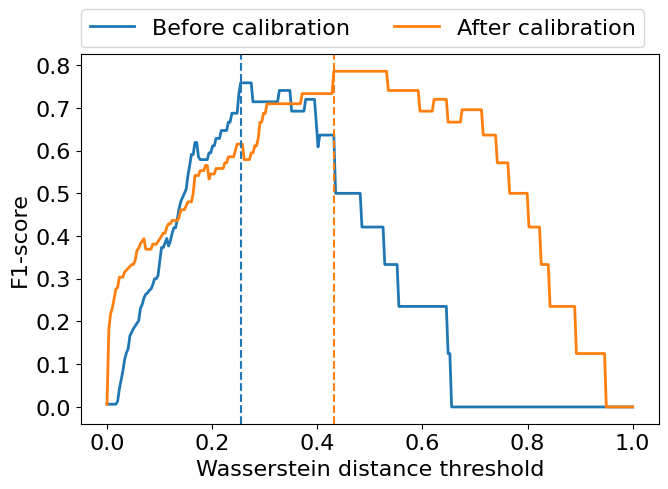

In [75]:
# plt.figure(figsize=(6, 4))
# plt.plot(f1_dict_start_cal.keys(), f1_dict_start_cal.values(), label="F1 (asymmetric)")
# plt.plot(f1_m2_list_start_cal.keys(), f1_m2_list_start_cal.values(), label="F1 (m = 2)")
# plt.axvline(best_th_start_cal, c="r", linestyle="--", label="Optimal threshold")
# plt.xlabel("Wasserstein threshold", fontsize=10)
# plt.ylabel("F1", fontsize=10)
# plt.title(
#     "F1 vs Wasserstein (start) threshold. BCE Explosions Beta-calibrated", fontsize=12
# )
# plt.legend(fontsize=10)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.show()

plt.figure(figsize=(7, 5))
plt.plot(
    f1_dict_prev.keys(),
    f1_dict_prev.values(),
    # marker="o",
    # markersize=2,
    linewidth=2,
    label="Before calibration",
    c=c0,
)
plt.plot(
    f1_dict_prev_cal.keys(),
    f1_dict_prev_cal.values(),
    # marker="o",
    # markersize=2,
    linewidth=2,
    label="After calibration",
    c=c1,
)
plt.axvline(best_th_prev, linestyle="--", c=c0)  # label="$h^{*}$ before calibration"
plt.axvline(best_th_prev_cal, linestyle="--", c=c1)  # label="$h^{*}$ after calibration"
plt.xlabel("Wasserstein distance threshold", fontsize=FONTSIZE)
plt.ylabel("F1-score", fontsize=FONTSIZE)
plt.legend(
    fontsize=FONTSIZE,
    bbox_to_anchor=(0, 1.02, 1, 0.2),
    loc="lower left",
    borderaxespad=0,
    ncol=2,
)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig("pictures/calibration/th_graphs/th_range_explosions.pdf", dpi=300)
plt.show()

# Road Accidents

In [80]:
model_type = "seq2seq"

experiments_name = "explosion"
path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"
path_to_models_folder = "saved_models/bce/road_accidents/layer_norm/ens_1"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

_, val_dataset = train_test_split(train_dataset, test_size=0.4, random_state=42)
val_dataloader = DataLoader(
    val_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [81]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

In [82]:
test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_bce,
    test_dataloader,
    model_type="ensemble_all_models",
    device="cuda",
    verbose=True,
)

out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)
out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

# res_start, best_th_start = evaluate_distance_ensemble_model(
#     ens_model=ens_bce,
#     threshold_list=threshold_list,
#     output_dataloader=out_dataloader,
#     margin_list=[1, 2, 4],
#     window_size=2,
#     anchor_window_type="start",
#     distance="wasserstein_1d",
#     device="cpu",
#     verbose=True,
# )

res_prev, best_th_prev = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="prev",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 102/102 [01:58<00:00,  1.16s/it]

Results for best threshold = 0.29763488497442225
AUDC: 0.0, Time to FA: 15.6635, DD: 0.1333, F1: 0.7143, Cover: 0.9861, Max Cover: 0.9861
Max F1 with margin 1: 0.4348
Max F1 with margin 2: 0.6154
Max F1 with margin 4: 0.7586


In [5]:
outs_tensor = torch.hstack([out for out in test_out_bank])
labels_tensor = torch.vstack([labels for labels in test_labels_bank])
outs_tensor.shape, labels_tensor.shape

(torch.Size([10, 315, 16]), torch.Size([315, 16]))

In [6]:
torch.save(outs_tensor, "saved_outputs/bce/road_accidents/all_models_ens_1_outputs.pt")
torch.save(labels_tensor, "saved_outputs/bce/road_accidents/all_models_ens_1_labels.pt")

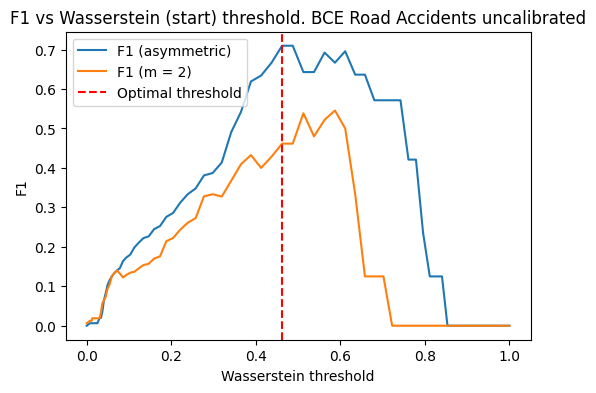

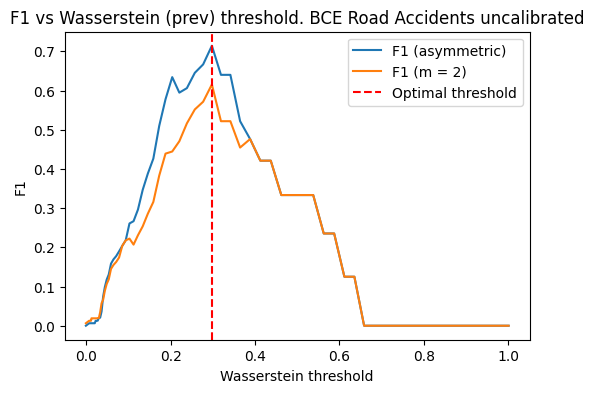

In [7]:
# f1_dict_start = {th: v[3] for th, v in res_start.items()}
# f1_m2_list_start = {th: v[6][2] for th, v in res_start.items()}

# f1_dict_prev = {th: v[3] for th, v in res_prev.items()}
# f1_m2_list_prev = {th: v[6][2] for th, v in res_prev.items()}

# plt.figure(figsize=(6, 4))
# plt.plot(f1_dict_start.keys(), f1_dict_start.values(), label="F1 (asymmetric)")
# plt.plot(f1_m2_list_start.keys(), f1_m2_list_start.values(), label="F1 (m = 2)")
# plt.axvline(best_th_start, c="r", linestyle="--", label="Optimal threshold")
# plt.xlabel("Wasserstein threshold", fontsize=10)
# plt.ylabel("F1", fontsize=10)
# plt.title(
#     "F1 vs Wasserstein (start) threshold. BCE Road Accidents uncalibrated", fontsize=12
# )
# plt.legend(fontsize=10)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.show()

# plt.figure(figsize=(6, 4))
# plt.plot(f1_dict_prev.keys(), f1_dict_prev.values(), label="F1 (asymmetric)")
# plt.plot(f1_m2_list_prev.keys(), f1_m2_list_prev.values(), label="F1 (m = 2)")
# plt.axvline(best_th_prev, c="r", linestyle="--", label="Optimal threshold")
# plt.xlabel("Wasserstein threshold", fontsize=10)
# plt.ylabel("F1", fontsize=10)
# plt.title(
#     "F1 vs Wasserstein (prev) threshold. BCE Road Accidents uncalibrated", fontsize=12
# )
# plt.legend(fontsize=10)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.show()

In [83]:
cal_models_list = calibrate_all_models_in_ensemble(
    ens_bce,
    val_dataloader,
    cal_type="beta",
    verbose=True,
    device="cuda",
)

test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_bce,
    test_dataloader,
    model_type="ensemble_all_models",
    device="cuda",
    verbose=True,
)

out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)

out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

# res_start_cal, best_th_start_cal = evaluate_distance_ensemble_model(
#     ens_model=ens_bce,
#     threshold_list=threshold_list,
#     output_dataloader=out_dataloader,
#     margin_list=[1, 2, 4],
#     window_size=2,
#     anchor_window_type="start",
#     distance="wasserstein_1d",
#     device="cpu",
#     verbose=True,
# )

res_prev_cal, best_th_prev_cal = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="prev",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 102/102 [01:57<00:00,  1.16s/it]

Results for best threshold = 0.6354235592583607
AUDC: 0.0, Time to FA: 15.7333, DD: 0.1968, F1: 0.72, Cover: 0.9839, Max Cover: 0.9839
Max F1 with margin 1: 0.2222
Max F1 with margin 2: 0.5455
Max F1 with margin 4: 0.6087


In [9]:
outs_tensor = torch.hstack([out for out in test_out_bank])
labels_tensor = torch.vstack([labels for labels in test_labels_bank])

torch.save(
    outs_tensor, "saved_outputs/bce/road_accidents/all_models_ens_1_outputs_cal.pt"
)
torch.save(
    labels_tensor, "saved_outputs/bce/road_accidents/all_models_ens_1_labels_cal.pt"
)

In [84]:
# f1_dict_start_cal = {th: v[3] for th, v in res_start_cal.items()}
# f1_m2_list_start_cal = {th: v[6][2] for th, v in res_start_cal.items()}

f1_dict_prev = {th: v[3] for th, v in res_prev.items()}
f1_dict_prev_cal = {th: v[3] for th, v in res_prev_cal.items()}
# f1_m2_list_prev_cal = {th: v[6][2] for th, v in res_prev_cal.items()}

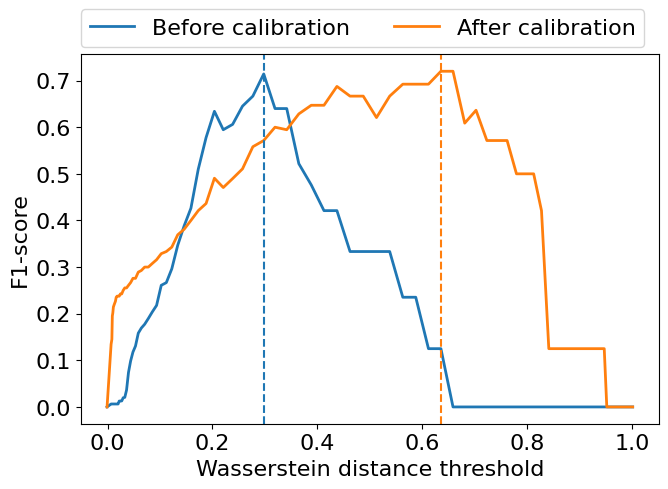

In [86]:
plt.figure(figsize=(7, 5))
plt.plot(
    f1_dict_prev.keys(),
    f1_dict_prev.values(),
    linewidth=2,
    label="Before calibration",
    c=c0,
)
plt.plot(
    f1_dict_prev_cal.keys(),
    f1_dict_prev_cal.values(),
    linewidth=2,
    label="After calibration",
    c=c1,
)
plt.axvline(best_th_prev, linestyle="--", c=c0)  # label="$h^{*}$ before calibration"
plt.axvline(best_th_prev_cal, linestyle="--", c=c1)  # label="$h^{*}$ after calibration"
plt.xlabel("Wasserstein distance threshold", fontsize=FONTSIZE)
plt.ylabel("F1-score", fontsize=FONTSIZE)
plt.legend(
    fontsize=FONTSIZE,
    bbox_to_anchor=(0, 1.02, 1, 0.2),
    loc="lower left",
    borderaxespad=0,
    ncol=2,
)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig("pictures/calibration/th_graphs/th_range_road_accidents.pdf", dpi=300)
plt.show()

# CP scores histograms

In [3]:
import math

import numpy as np
from ot import wasserstein_1d
from sklearn.model_selection import train_test_split
from src.metrics.metrics_utils import collect_model_predictions_on_set

In [50]:
# def get_scores_collections(
#     test_out_bank, test_labels_bank, test_uncertainties_bank, half_window=1
# ):
#     normal_scores_list = []
#     cp_scores_list = []
#     trans_scores_list = []

#     for preds_mean, labels, preds_std in zip(
#         test_out_bank, test_labels_bank, test_uncertainties_bank
#     ):
#         cp_idxs_batch = labels.cpu().argmax(axis=1)

#         for cp_idx, mean_series in zip(cp_idxs_batch, preds_mean):
#             if cp_idx == 0:
#                 normal_scores_list.extend(mean_series.numpy().tolist())
#             elif cp_idx < half_window + 1:
#                 trans_slice = mean_series[: cp_idx + half_window]
#                 cp_slice = mean_series[cp_idx + half_window :]

#                 trans_scores_list.extend(trans_slice.numpy().tolist())
#                 cp_scores_list.extend(cp_slice.numpy().tolist())

#             else:
#                 normal_slice = mean_series[: cp_idx - half_window]
#                 trans_slice = mean_series[cp_idx - half_window : cp_idx + half_window]
#                 cp_slice = mean_series[cp_idx + half_window :]

#                 normal_scores_list.extend(normal_slice.numpy().tolist())
#                 trans_scores_list.extend(trans_slice.numpy().tolist())
#                 cp_scores_list.extend(cp_slice.numpy().tolist())

#     return normal_scores_list, cp_scores_list, trans_scores_list

In [4]:
def get_scores_collections_binary(
    test_out_bank, test_labels_bank, test_uncertainties_bank
):
    normal_scores_list = []
    cp_scores_list = []

    for preds_mean, labels, preds_std in zip(
        test_out_bank, test_labels_bank, test_uncertainties_bank
    ):
        cp_idxs_batch = labels.cpu().argmax(axis=1)

        for cp_idx, mean_series in zip(cp_idxs_batch, preds_mean):
            if cp_idx == 0:
                normal_scores_list.extend(mean_series.numpy().tolist())
            else:
                normal_slice = mean_series[:cp_idx]
                cp_slice = mean_series[cp_idx:]

                normal_scores_list.extend(normal_slice.numpy().tolist())
                cp_scores_list.extend(cp_slice.numpy().tolist())

    return normal_scores_list, cp_scores_list

# HAR

In [32]:
model_type = "seq2seq"

experiments_name = "human_activity"
path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"
path_to_models_folder = "saved_models/bce/human_activity/full_sample/ens_1"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

_, val_dataset = train_test_split(train_dataset, test_size=0.4, random_state=42)
val_dataloader = DataLoader(
    val_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

## Uncalibrated

In [33]:
test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        model=ens_bce, test_loader=test_dataloader, model_type="ensemble", device="cpu"
    )
)

normal_scores_list, cp_scores_list = get_scores_collections_binary(
    test_out_bank, test_labels_bank, test_uncertainties_bank
)

len(normal_scores_list), len(cp_scores_list)

 10%|▉         | 2/21 [00:00<00:01, 13.09it/s]

Collectting model's outputs


100%|██████████| 21/21 [00:01<00:00, 16.47it/s]


(15317, 11423)

In [34]:
ws_1 = wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=1)

ws_2 = math.sqrt(
    wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=2)
)

print(f"W_1 = {np.round(ws_1, 3)}, W_2 = {np.round(ws_2, 3)}")

W_1 = 0.943, W_2 = 0.956


In [35]:
BINS = 50
DENSITY = True
FONTSIZE = 16
ALPHA = 0.5

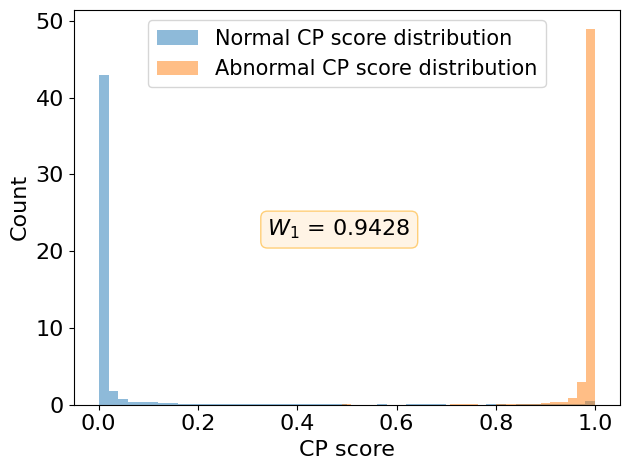

In [36]:
plt.figure()
plt.hist(
    normal_scores_list,
    bins=BINS,
    density=DENSITY,
    label="Normal CP score distribution",
    alpha=ALPHA,
)

plt.hist(
    cp_scores_list,
    bins=BINS,
    density=DENSITY,
    label="Abnormal CP score distribution",
    alpha=ALPHA,
)
bbox = dict(boxstyle="round", fc="blanchedalmond", ec="orange", alpha=ALPHA)
plt.text(
    x=0.34,
    y=22,
    s="$W_1$ = {:.4f}".format(ws_1, 4),  # noqa: F523
    fontsize=FONTSIZE,
    bbox=bbox,
)
plt.legend(loc="upper center", fontsize=FONTSIZE - 1)
plt.xlabel("CP score", fontsize=FONTSIZE)
plt.ylabel("Count", fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig("pictures/calibration/histograms/histogram_har_before.pdf", dpi=300)
plt.show()

# Beta-calibrated

In [37]:
cal_models_list = calibrate_all_models_in_ensemble(
    ens_bce,
    val_dataloader,
    cal_type="beta",
    verbose=False,
    device="cpu",
)

test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        model=ens_bce, test_loader=test_dataloader, model_type="ensemble", device="cpu"
    )
)

normal_scores_list, cp_scores_list = get_scores_collections_binary(
    test_out_bank, test_labels_bank, test_uncertainties_bank
)

len(normal_scores_list), len(cp_scores_list)

 10%|▉         | 2/21 [00:00<00:01, 13.37it/s]

Collectting model's outputs


100%|██████████| 21/21 [00:01<00:00, 17.82it/s]


(15317, 11423)

In [38]:
ws_1 = wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=1)

ws_2 = math.sqrt(
    wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=2)
)

print(f"W_1 = {np.round(ws_1, 3)}, W_2 = {np.round(ws_2, 3)}")

W_1 = 0.95, W_2 = 0.964


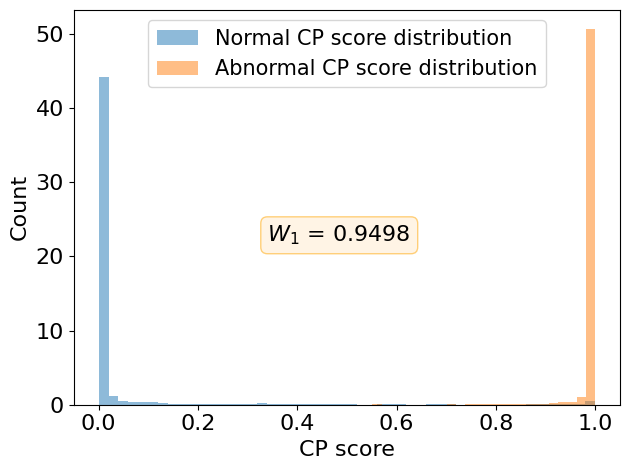

In [40]:
plt.figure()
plt.hist(
    normal_scores_list,
    bins=BINS,
    density=DENSITY,
    label="Normal CP score distribution",
    alpha=ALPHA,
)

plt.hist(
    cp_scores_list,
    bins=BINS,
    density=DENSITY,
    label="Abnormal CP score distribution",
    alpha=ALPHA,
)
bbox = dict(boxstyle="round", fc="blanchedalmond", ec="orange", alpha=ALPHA)
plt.text(
    x=0.34,
    y=22,
    s="$W_1$ = {:.4f}".format(ws_1, 4),  # noqa: F523
    fontsize=FONTSIZE,
    bbox=bbox,
)
plt.legend(loc="upper center", fontsize=FONTSIZE - 1)
plt.xlabel("CP score", fontsize=FONTSIZE)
plt.ylabel("Count", fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig("pictures/calibration/histograms/histogram_har_after.pdf", dpi=300)
plt.show()

# Explosions

In [41]:
model_type = "seq2seq"

experiments_name = "explosion"
path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"
path_to_models_folder = (
    "saved_models/bce/explosion/layer_norm/train_anomaly_num_155/ens_1"
)

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

_, val_dataset = train_test_split(train_dataset, test_size=0.4, random_state=42)
val_dataloader = DataLoader(
    val_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

# Uncalibrated

In [42]:
test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        model=ens_bce, test_loader=test_dataloader, model_type="ensemble", device="cuda"
    )
)

normal_scores_list, cp_scores_list = get_scores_collections_binary(
    test_out_bank, test_labels_bank, test_uncertainties_bank
)

len(normal_scores_list), len(cp_scores_list)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [02:48<00:00,  8.43s/it]


(4929, 111)

In [43]:
ws_1 = wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=1)

ws_2 = math.sqrt(
    wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=2)
)

print(f"W_1 = {np.round(ws_1, 3)}, W_2 = {np.round(ws_2, 3)}")

W_1 = 0.547, W_2 = 0.591


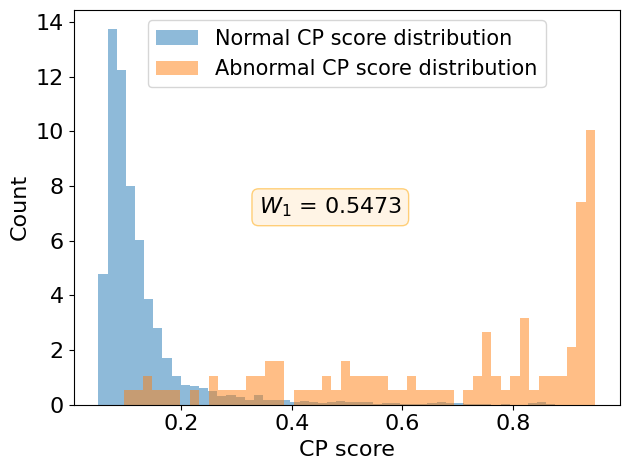

In [48]:
plt.figure()
plt.hist(
    normal_scores_list,
    bins=BINS,
    density=DENSITY,
    label="Normal CP score distribution",
    alpha=ALPHA,
)

plt.hist(
    cp_scores_list,
    bins=BINS,
    density=DENSITY,
    label="Abnormal CP score distribution",
    alpha=ALPHA,
)
bbox = dict(boxstyle="round", fc="blanchedalmond", ec="orange", alpha=ALPHA)
plt.text(
    x=0.34,
    y=7,
    s="$W_1$ = {:.4f}".format(ws_1, 4),  # noqa: F523
    fontsize=FONTSIZE,
    bbox=bbox,
)
plt.legend(loc="upper center", fontsize=FONTSIZE - 1)
plt.xlabel("CP score", fontsize=FONTSIZE)
plt.ylabel("Count", fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig("pictures/calibration/histograms/histogram_explosions_before.pdf", dpi=300)
plt.show()

# Beta-calibrated

In [49]:
cal_models_list = calibrate_all_models_in_ensemble(
    ens_bce,
    val_dataloader,
    cal_type="beta",
    verbose=True,
    device="cuda",
)

test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        model=ens_bce,
        test_loader=test_dataloader,
        model_type="ensemble",
        device="cuda",
        verbose=True,
    )
)

normal_scores_list, cp_scores_list = get_scores_collections_binary(
    test_out_bank, test_labels_bank, test_uncertainties_bank
)

len(normal_scores_list), len(cp_scores_list)

  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [02:47<00:00,  8.39s/it]


(4929, 111)

In [51]:
ws_1 = wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=1)

ws_2 = math.sqrt(
    wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=2)
)

print(f"W_1 = {np.round(ws_1, 3)}, W_2 = {np.round(ws_2, 3)}")

W_1 = 0.668, W_2 = 0.758


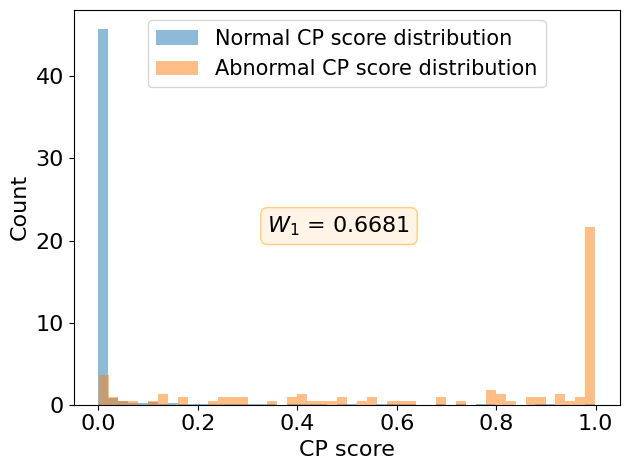

In [56]:
plt.figure()
plt.hist(
    normal_scores_list,
    bins=BINS,
    density=DENSITY,
    label="Normal CP score distribution",
    alpha=ALPHA,
)

plt.hist(
    cp_scores_list,
    bins=BINS,
    density=DENSITY,
    label="Abnormal CP score distribution",
    alpha=ALPHA,
)
bbox = dict(boxstyle="round", fc="blanchedalmond", ec="orange", alpha=ALPHA)
plt.text(
    x=0.34,
    y=21,
    s="$W_1$ = {:.4f}".format(ws_1, 4),  # noqa: F523
    fontsize=FONTSIZE,
    bbox=bbox,
)
plt.legend(loc="upper center", fontsize=FONTSIZE - 1)
plt.xlabel("CP score", fontsize=FONTSIZE)
plt.ylabel("Count", fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig("pictures/calibration/histograms/histogram_explosions_after.pdf", dpi=300)
plt.show()

# Road Accidents

In [57]:
model_type = "seq2seq"

experiments_name = "explosion"
path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"
path_to_models_folder = "saved_models/bce/road_accidents/layer_norm/ens_1"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

_, val_dataset = train_test_split(train_dataset, test_size=0.4, random_state=42)
val_dataloader = DataLoader(
    val_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

## Uncalibrated

In [58]:
test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        model=ens_bce, test_loader=test_dataloader, model_type="ensemble", device="cuda"
    )
)

# normal_scores_list, cp_scores_list, trans_scores_list = get_scores_collections(
#     test_out_bank, test_labels_bank, test_uncertainties_bank, half_window=1
# )

normal_scores_list, cp_scores_list = get_scores_collections_binary(
    test_out_bank, test_labels_bank, test_uncertainties_bank
)

len(normal_scores_list), len(cp_scores_list)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [02:53<00:00,  8.68s/it]


(4929, 111)

In [59]:
ws_1 = wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=1)

ws_2 = math.sqrt(
    wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=2)
)

print(ws_1, ws_2)

0.5213028254725762 0.5505003084692456


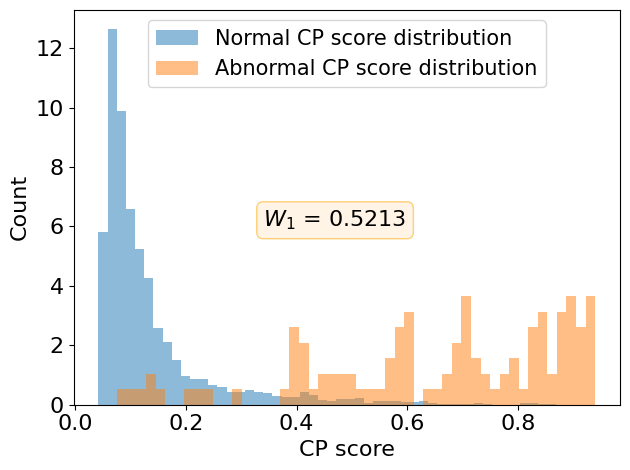

In [62]:
plt.figure()
plt.hist(
    normal_scores_list,
    bins=BINS,
    density=DENSITY,
    label="Normal CP score distribution",
    alpha=ALPHA,
)

plt.hist(
    cp_scores_list,
    bins=BINS,
    density=DENSITY,
    label="Abnormal CP score distribution",
    alpha=ALPHA,
)
bbox = dict(boxstyle="round", fc="blanchedalmond", ec="orange", alpha=ALPHA)
plt.text(
    x=0.34,
    y=6,
    s="$W_1$ = {:.4f}".format(ws_1, 4),  # noqa: F523
    fontsize=FONTSIZE,
    bbox=bbox,
)
plt.legend(loc="upper center", fontsize=FONTSIZE - 1)
plt.xlabel("CP score", fontsize=FONTSIZE)
plt.ylabel("Count", fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig(
    "pictures/calibration/histograms/histogram_road_accidents_before.pdf", dpi=300
)
plt.show()

## Beta-calibrated

In [63]:
cal_models_list = calibrate_all_models_in_ensemble(
    ens_bce,
    val_dataloader,
    cal_type="beta",
    verbose=True,
    device="cuda",
)

test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        model=ens_bce,
        test_loader=test_dataloader,
        model_type="ensemble",
        device="cuda",
        verbose=True,
    )
)

# normal_scores_list, cp_scores_list, trans_scores_list = get_scores_collections(
#     test_out_bank, test_labels_bank, test_uncertainties_bank, half_window=1
# )

normal_scores_list, cp_scores_list = get_scores_collections_binary(
    test_out_bank, test_labels_bank, test_uncertainties_bank
)

len(normal_scores_list), len(cp_scores_list)

  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [02:48<00:00,  8.45s/it]


(4929, 111)

In [64]:
ws_1 = wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=1)

ws_2 = math.sqrt(
    wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=2)
)

print(ws_1, ws_2)

0.6637315688685312 0.7437181826153959


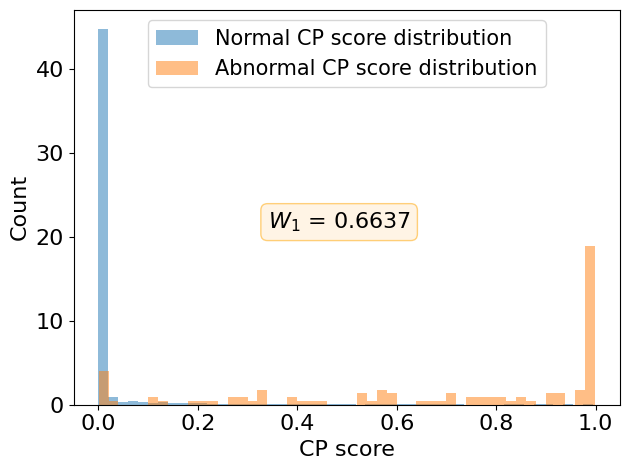

In [66]:
plt.figure()
plt.hist(
    normal_scores_list,
    bins=BINS,
    density=DENSITY,
    label="Normal CP score distribution",
    alpha=ALPHA,
)

plt.hist(
    cp_scores_list,
    bins=BINS,
    density=DENSITY,
    label="Abnormal CP score distribution",
    alpha=ALPHA,
)
bbox = dict(boxstyle="round", fc="blanchedalmond", ec="orange", alpha=ALPHA)
plt.text(
    x=0.34,
    y=21,
    s="$W_1$ = {:.4f}".format(ws_1, 4),  # noqa: F523
    fontsize=FONTSIZE,
    bbox=bbox,
)
plt.legend(loc="upper center", fontsize=FONTSIZE - 1)
plt.xlabel("CP score", fontsize=FONTSIZE)
plt.ylabel("Count", fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig(
    "pictures/calibration/histograms/histogram_road_accidents_after.pdf", dpi=300
)
plt.show()

In [37]:
ws_1 = wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=1)

ws_2 = math.sqrt(
    wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=2)
)

print(ws_1, ws_2)

0.6637315688685312 0.7437181826153959
